In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm

from sklearn.model_selection import StratifiedKFold

In [5]:
pd.set_option('display.max_columns', None)  # Set to None to display all columns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


----------------------
# EDA #
----------------------

In [6]:
# Import Data: 
train  = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test  = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

In [7]:
# First look at the data:
print("\nFirst four rows: \n")
display(train[:4])

def summary(df):
    print(f'\n\nData Shape: {df.shape} \n\n')
    print("Variable Type, Distribution, and Missingness: \n")
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#Missing'] = df.isnull().sum().values 
    summ['%Missing'] = df.isnull().sum().values / len(df)* 100
    summ['#Unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['Mean'] = desc['mean'].values
    summ['SD'] = desc['std'].values
    summ['max'] = desc['max'].values
    summ['75%'] = df.quantile(.75)
    summ['50%'] = df.quantile(.50)
    summ['25%'] = df.quantile(.25)
    summ['min'] = desc['min'].values
    
    return summ.T

summary(train)


First four rows: 



,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697



Data Shape: (200000, 202) 


Variable Type, Distribution, and Missingness: 



,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
data type,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
#Missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
%Missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

_______________

Observations:
* No missingness, and no non-numeric columns
* Really big SD's for several variables
* Everything seems to be in a relatively narrow range, though with some outliers. That said, it'll all need to be standardized. 
_______________

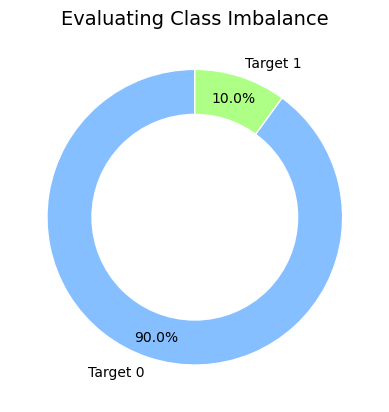

In [8]:
def plot_target(train):

    colors = ['#86BFFF', '#ADFF86']
    class_counts = train['target'].value_counts()
    class_labels = {0: "Target 0", 1: "Target 1"}
    class_labels = [class_labels.get(cls) for cls in class_counts.index]

    # Create the donut chart
    plt.pie(class_counts, labels=class_labels, autopct="%1.1f%%",
            colors=colors, startangle=90,
            pctdistance=0.85, wedgeprops={'edgecolor': 'white'})

    # Draw the center circle (donut hole)
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)

    # Adding the title of the chart
    plt.title("Evaluating Class Imbalance", fontsize=14)

    # Display the chart
    plt.show()

# Run it:
plot_target(train)

The data are unbalanced with respect to the target 

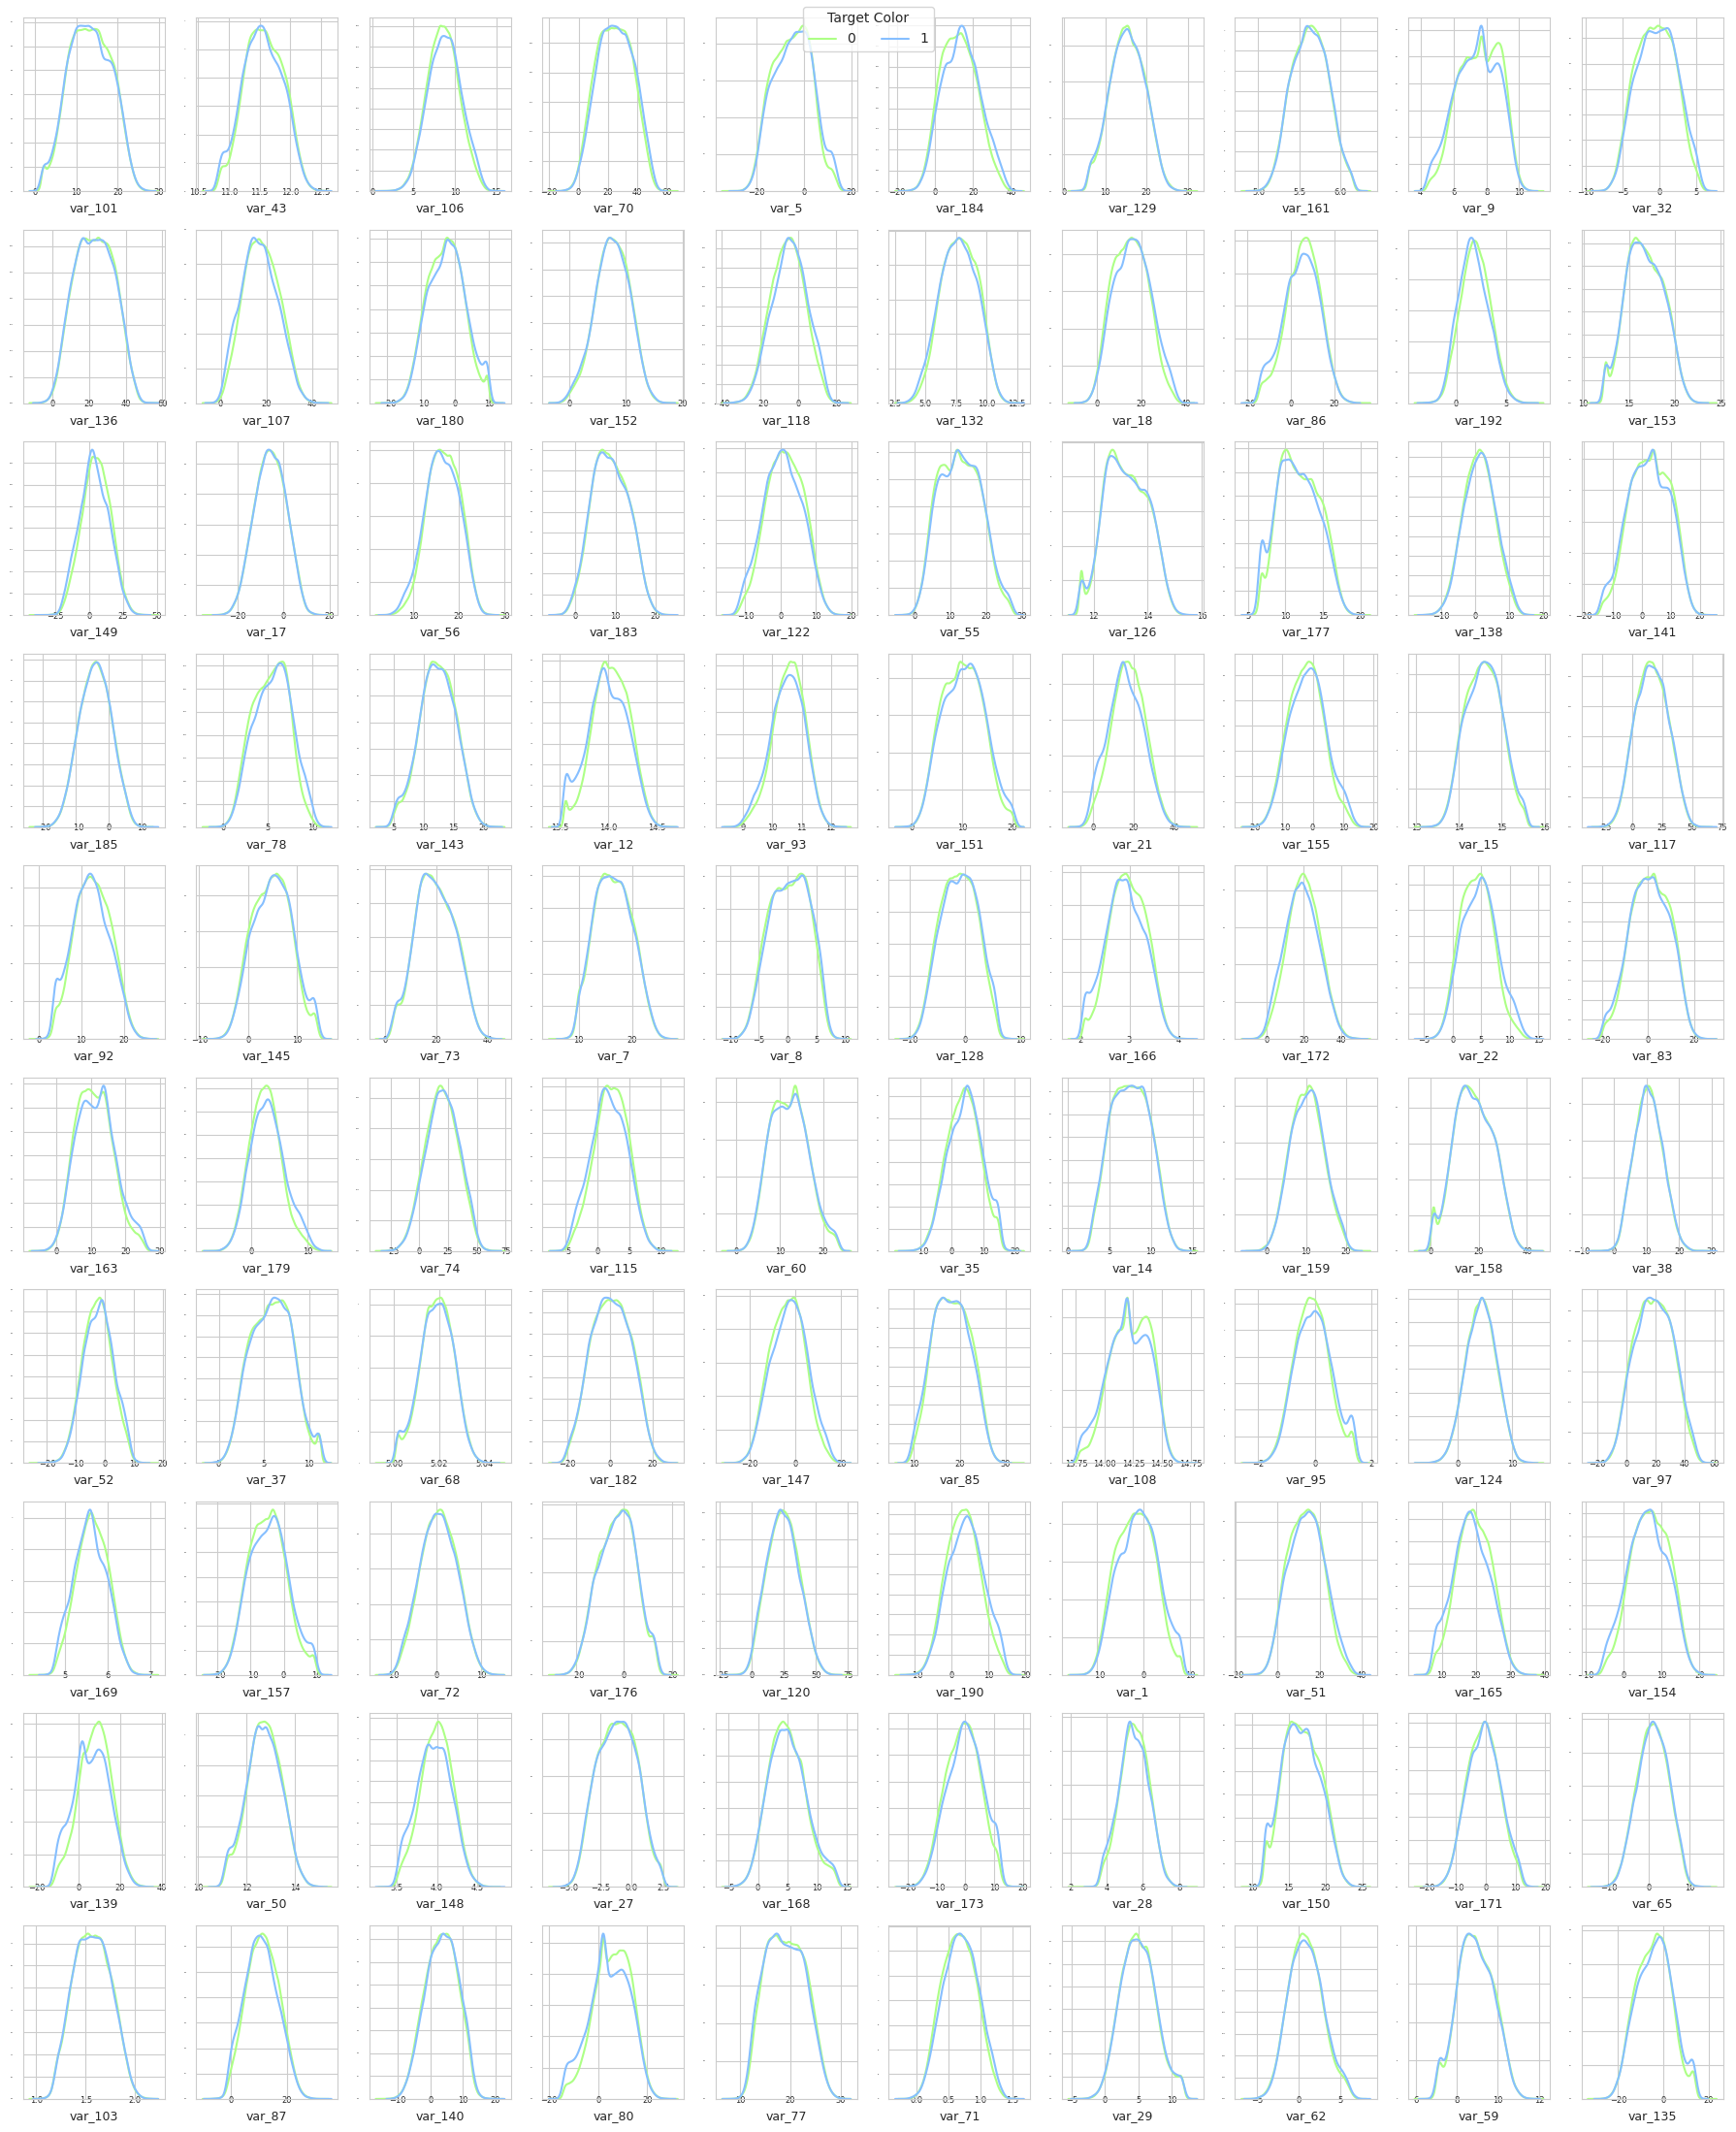

In [9]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18, 22))
    num_plots = len(features)
    rows = int(np.sqrt(num_plots))
    cols = (num_plots + rows - 1) // rows

    for i, feature in enumerate(features, start=1):
        plt.subplot(rows, cols, i)
        sns.distplot(df1[feature], hist=False, label=label1, color='#ADFF86')
        sns.distplot(df2[feature], hist=False, label=label2, color='#86BFFF')
        plt.xlabel(feature, fontsize=9)
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=0)
        plt.ylabel('')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='upper center', ncol=2, title='Target Color')
        
    plt.tight_layout()
    plt.show()

features = np.random.choice(train.columns.values[2:], size=100, replace=False)
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plot_feature_distribution(t0, t1, '0', '1', features)


Generally pretty good overlap between the two lines, but some variables where the difference appears significant. 

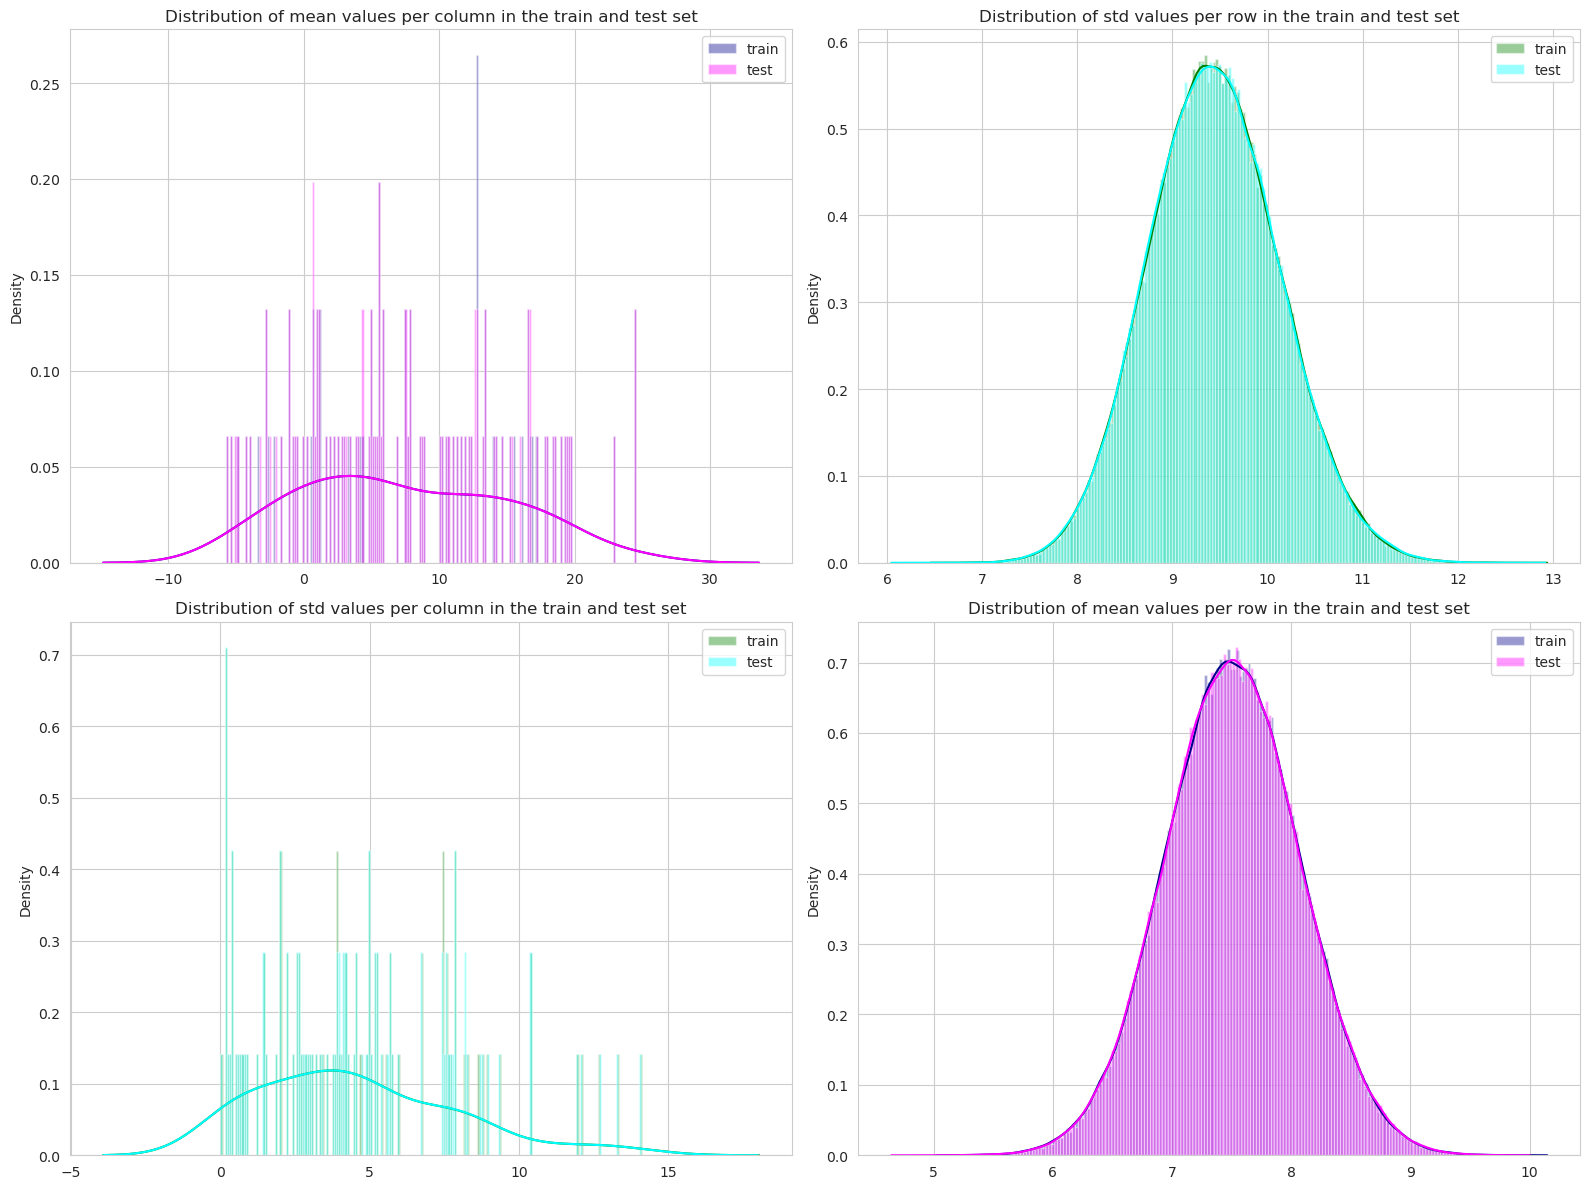

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Plot 1: Distribution of mean values per column in the train and test set
axes[0, 0].set_title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0), color="darkblue", kde=True, bins=200, label='train', ax=axes[0, 0])
sns.distplot(test[features].mean(axis=0), color="magenta", kde=True, bins=200, label='test', ax=axes[0, 0])
axes[0, 0].legend()

# Plot 2: Distribution of mean values per row in the train and test set 
axes[1, 1].set_title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1), color="darkblue", kde=True, bins=200, label='train', ax=axes[1, 1])
sns.distplot(test[features].mean(axis=1), color="magenta", kde=True, bins=200, label='test', ax=axes[1, 1])
axes[1, 1].legend()

# Plot 3: Distribution of std values per column in the train and test set
axes[0, 1].set_title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1), color="green", kde=True, bins=200, label='train', ax=axes[0, 1])
sns.distplot(test[features].std(axis=1), color="cyan", kde=True, bins=200, label='test', ax=axes[0, 1])
axes[0, 1].legend()

# Plot 4: Distribution of std values per row in the train and test set (axis=0)
axes[1, 0].set_title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0), color="green", kde=True, bins=200, label='train', ax=axes[1, 0])
sns.distplot(test[features].std(axis=0), color="cyan", kde=True, bins=200, label='test', ax=axes[1, 0])
axes[1, 0].legend()


# Adjust spacing between subplots
plt.tight_layout()

plt.show()

Okay, yeah, I'll need to standardize our features. Also good confirmation of the central limit theorem! 

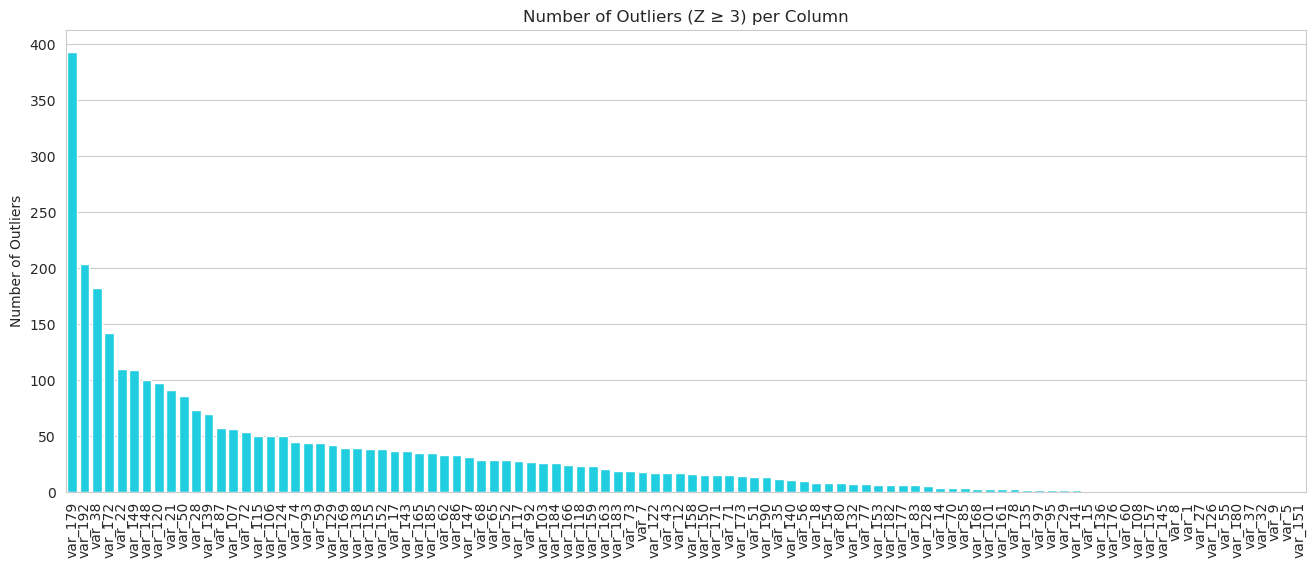

In [11]:
plt.figure(figsize=(16, 6))
plt.title("Number of Outliers (Z ≥ 3) per Column")

# Calculate the threshold for outliers
threshold = 3  # Number of standard deviations

# Calculate the number of outliers for each column
outliers_t0 = (t0[features] > t0[features].mean() + threshold * t0[features].std()).sum()
outliers_t1 = (t1[features] > t1[features].mean() + threshold * t1[features].std()).sum()

# Create a DataFrame to hold outlier counts and feature names
outliers_df = pd.DataFrame({'feature': features, 'outliers_t0': outliers_t0, 'outliers_t1': outliers_t1})

# Calculate the total number of outliers across both target groups
outliers_df['total_outliers'] = outliers_df['outliers_t0'] + outliers_df['outliers_t1']

# Sort the DataFrame by the total number of outliers
outliers_df = outliers_df.sort_values(by='total_outliers', ascending=False)

# Plot the number of outliers per column (sorted)
sns.barplot(x='feature', y='total_outliers', data=outliers_df, color="#00E8FF")

plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Number of Outliers")
plt.show()

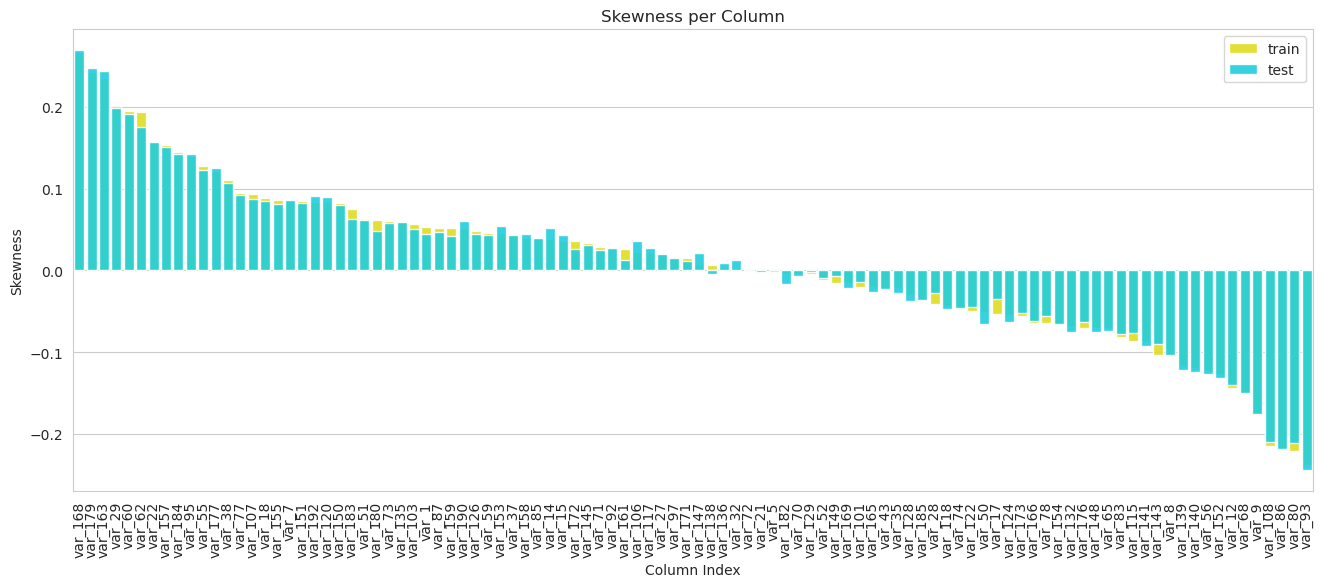

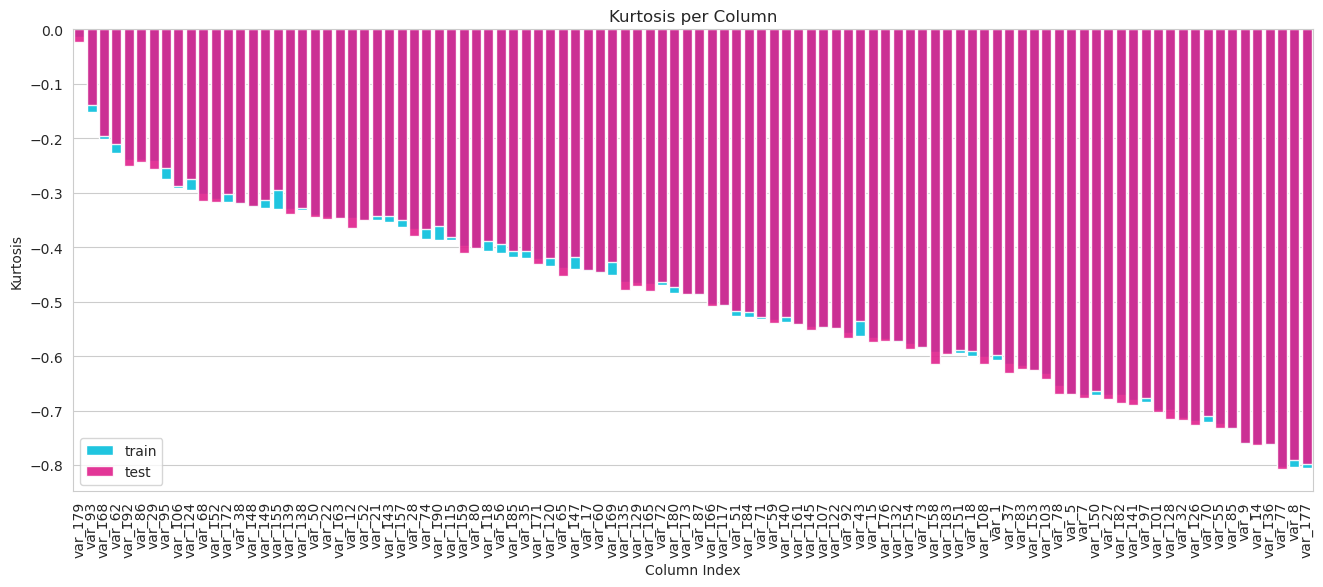

In [12]:
# Skewness Plot: 
plt.figure(figsize=(16, 6))
plt.title("Skewness per Column")

# Calculate skewness for train and test data
train_skewness = train[features].skew()
test_skewness = test[features].skew()

# Sort the features by skewness for both train and test
train_skewness_sorted = train_skewness.sort_values(ascending=False)
test_skewness_sorted = test_skewness[train_skewness_sorted.index]  # Match feature order

# Plot skewness for train data
sns.barplot(x=train_skewness_sorted.index, y=train_skewness_sorted, color="#FFFB00", alpha=0.9, label="train")

# Plot skewness for test data
sns.barplot(x=train_skewness_sorted.index, y=test_skewness_sorted, color='#00E8FF', alpha=0.9, label="test")

plt.xticks(rotation=90)
plt.xlabel("Column Index")
plt.ylabel("Skewness")
plt.legend()
plt.show()

# Kurtosis Plot: 
plt.figure(figsize=(16, 6))
plt.title("Kurtosis per Column")

# Calculate kurtosis for train and test data
train_kurtosis = train[features].kurtosis()
test_kurtosis = test[features].kurtosis()

# Sort the features by kurtosis for both train and test
train_kurtosis_sorted = train_kurtosis.sort_values(ascending=False)
test_kurtosis_sorted = test_kurtosis[train_kurtosis_sorted.index]  # Match feature order

# Plot kurtosis for train data
sns.barplot(x=train_kurtosis_sorted.index, y=train_kurtosis_sorted, color="#00DCFF", alpha=1, label="train")

# Plot kurtosis for test data
sns.barplot(x=test_kurtosis_sorted.index, y=test_kurtosis_sorted, color='#FF0090', alpha=0.9, label="test")

plt.xticks(rotation=90)
plt.xlabel("Column Index")
plt.ylabel("Kurtosis")
plt.legend()
plt.show()

Great, the skewness and kurtosis appear to be within an acceptable range. 


In [13]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

correlations.tail(10)

,level_0,level_1,0
9890,var_95,var_184,0.007804
9891,var_184,var_95,0.007804
9892,var_50,var_157,0.007859
9893,var_157,var_50,0.007859
9894,var_166,var_12,0.007929
9895,var_12,var_166,0.007929
9896,var_80,var_1,0.008855
9897,var_1,var_80,0.008855
9898,var_132,var_122,0.008956
9899,var_122,var_132,0.008956


----------------------
# Build the Model #
----------------------

In [ ]:
# Re-Import Data: 
train  = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test  = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

train_features = train.drop(['target', 'ID_code'], axis=1)
train_targets = train['target']
test_features = test.drop(['ID_code'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(train_features, train_targets, test_size = 0.25, random_state = 50)

input_dim = X_train.shape[1]


# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
test_features = sc.transform(test_features)


# Define a function to create the model
def create_model(units_1=200, dropout_1=0.2, units_2=200, dropout_2=0.1, units_3=100, dropout_3=0.1, units_4=50, kernel_regularizer=0.005):
    model = Sequential()
    model.add(Dense(units=units_1, activation="relu", input_dim=input_dim, kernel_initializer="normal", kernel_regularizer=regularizers.l2(kernel_regularizer), kernel_constraint=max_norm(5.)))
    model.add(Dropout(rate=dropout_1))
    model.add(Dense(units=units_2, activation='relu', kernel_regularizer=regularizers.l2(kernel_regularizer), kernel_constraint=max_norm(5)))
    model.add(Dropout(rate=dropout_2))
    model.add(Dense(units=units_3, activation='relu', kernel_regularizer=regularizers.l2(kernel_regularizer), kernel_constraint=max_norm(5)))
    model.add(Dropout(rate=dropout_3))
    model.add(Dense(units=units_4, activation='tanh', kernel_regularizer=regularizers.l2(kernel_regularizer), kernel_constraint=max_norm(5)))
    model.add(Dropout(rate=dropout_3))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16384, verbose=0)

# Define the hyperparameter grid for grid search
param_grid = {
    'units_1': [100, 200],
    'dropout_1': [0.2, 0.3],
    'units_2': [100, 200],
    'dropout_2': [0.1, 0.2],
    'units_3': [50, 100],
    'dropout_3': [0.1, 0.2],
    'units_4': [25, 50],
    'kernel_regularizer': [0.001, 0.005]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and AUC score
print("Best AUC: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))


/tmp/ipykernel_32/3009892158.py:46: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16384, verbose=0)


Fitting 3 folds for each of 256 candidates, totalling 768 fits
1563/1563 [==============================] - 2s 1ms/step
